# MCMC for a population model $ p(M|\alpha)= M^\alpha$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
np.random.seed(1234)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

We fit a BH mass functionsource parameter given by the mass, $\theta=M$. This example follows the EMRI mass function [e-Print: 1004.1921 ("GTV")]:

$$\frac{dN}{d\ln M}=A_0\big(\frac{M}{M_*}\big)^{\alpha_0} \quad\Rightarrow\quad p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}.$$

We are interested in the $ \lambda=\alpha_0$ population parameter. We are assuming that the amplitude $A_0$ does not carry information about the system, but only about the rate of events.

In [29]:
"""
Parameters
"""

N_obs = 1000
N_samp_per_obs = 30

# Inputs to get the true ln M distribution.
# Notice that M runs from 10^4 to 10^7 in GTV.

alpha0_t = 0.01
M_min=10000. ;   logM_min = np.log(M_min)
M_max=10000000.; logM_max = np.log(M_max)

In [30]:
def model(lnM,alpha):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data    (The noisy generated data where we expect the masses to be.)
    - alpha   (Spectral index of the mass distribution.)
    
    """
    
    M = np.exp(lnM) # mass 
    norm  = alpha/(M_max**alpha-M_min**alpha)
    
    
    return norm*M**(alpha-1)

In [31]:
alpha_min = -10.0
alpha_max = 10.0

def log_likelihood_generic(params, data):
    
    
    support = (
                (params[0] >= alpha_min)&
                (params[0] <= alpha_max)
                )
    
    log_likelihood=0
    
    for i in np.arange(N_obs):
        
        mod = model(data[i,:],params[0]) 
        log_likelihood += np.log(np.sum(mod)) 
        
    out = np.where(support,log_likelihood,-np.inf)
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf


Starting from the probability density $p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}$, we can use the method of inversion to get the source parameter M. In particular, we define the cumulative density function,

$u:=\text{CDF}(M)= \mathcal{N}\int_{M_\text{min}}^{M}M^{\alpha_0-1}dM = \alpha_0^{-1}\mathcal{N}M^{\alpha_0}\big|_{M_\text{min}}^{M}=\alpha_0^{-1}\mathcal{N}(M^{\alpha_0}-M^{\alpha_0}_{\text{min}})$.

The normalization factor can be calculated imposing that $\lim_{M\rightarrow M_{\text{min}}} u=1$, which gives immediately:

$\mathcal{N}=\frac{\alpha_0}{M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}}}$.

Now, we get M in terms of $u$, 

$\quad M^{\alpha_0}=\alpha_0\mathcal{N}^{-1} u +M^{\alpha_0}_{\text{min}}\quad\Longrightarrow \quad \ln M =\frac{1}{\alpha_0} \ln\big[(M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}})\, u +M^{\alpha_0}_{\text{min}}\big]\quad $ (true parameter distribution).

In [32]:
sigma = 0.1
noise = np.random.normal(0,sigma,size = N_obs)

"""
This changes with different models.
"""

u = np.random.uniform(size=N_obs)
logM_t=alpha0_t**-1 * np.log((M_max**(alpha0_t)-M_min**(alpha0_t))*u+ M_min**(alpha0_t)*np.ones(N_obs))

d_i = noise + logM_t  # observation model made of noise + true population.


"""
This does not change with different population models. 
Would change with different observation model, i.e., p(d|theta).
The structure of data is such that Data[i,j] is the jth posterior sample from event i.

"""

data=np.zeros((N_obs,N_samp_per_obs))
for i in np.arange(N_obs):
    
    data[i,:]=np.random.normal(d_i[i],sigma,size=N_samp_per_obs)

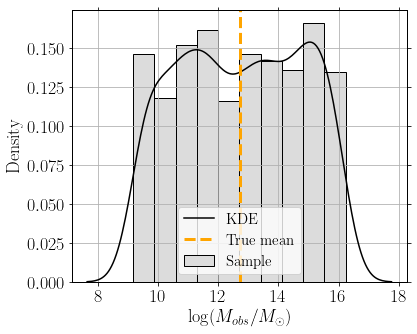

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(d_i,density=True,label='Sample',bins=10,histtype = 'bar',
                               color ='gainsboro', edgecolor='black')
sns.kdeplot(np.array(d_i), label='KDE',c='k')
plt.axvline(x=np.mean(logM_t), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend(loc='best')

In [34]:
"""
Choose which data and likelihood.
"""

which_likelihood = log_likelihood_generic
which_data = data

In [35]:
n_iter = 10000
ndim = 1; nwalkers = 2

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, which_likelihood, args=[which_data])

sampler.run_mcmc(p0, n_iter, progress=True)

100%|██████████| 10000/10000 [03:28<00:00, 47.98it/s]


State([[0.02978923]
 [0.01117163]], log_prob=[-11265.6916245  -11265.39701435], blobs=None, random_state=('MT19937', array([2337103049, 3004329904,  331367108, 3222724907, 3427232436,
       2058579211, 3968969911, 2642543805, 1940486542, 3621766194,
       2604480635, 3909569841, 4111968704,  782259301, 3724196602,
       1311805523,  431442807, 4292882686,  595153897, 1957604796,
       3789258805, 3262892885, 2149572184, 1358279899, 1323803838,
        787714257, 4063811042, 3542346758, 2176706454, 2045682059,
       2243292477, 3850199728, 1386660918,  722179840, 3431656859,
       1464014697, 1304505342, 2068974185, 4151463653,  241036555,
        404579666, 4233683707, 1706966850, 1483598990, 1484048645,
       1942172136, 1553328587,  481281905, 4282889958, 2677534790,
       3628564942, 2092547544, 1044260313, 1611392137, 1493926240,
       3874269322, 2417188117,  541618767, 2152036780,  694072639,
       1415089584, 3847695093, 2132836865,  635035194, 3465978967,
       32787

In [36]:
"""
Collect the samples here.
"""
burnin = 1500

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
alpha_samples = chains[:,:,0].flatten()

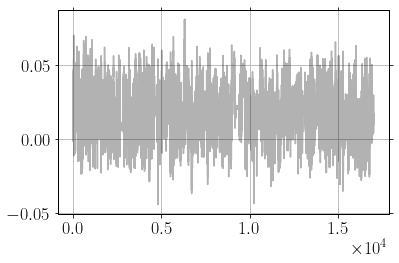

In [37]:
plt.plot(alpha_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

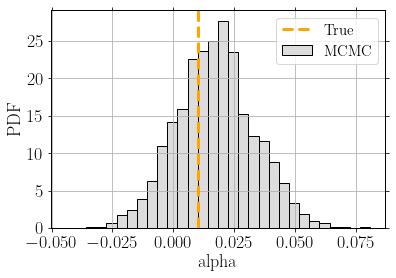

In [38]:
"""
Posteriors with Fisher estimates
"""


_, bins_alpha, _= plt.hist(alpha_samples, 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')

plt.axvline(x=alpha0_t, label='True', c='orange',ls='--',lw=3)
plt.xlabel('alpha')
plt.ylabel('PDF')
plt.legend()
plt.show()